MedOptix AI - A project on Health sector to predict patients who are likely to dropout of therapy

- Import All Necessary Libraries

In [179]:
# Import dependencies
import boto3
import os
import sqlalchemy
import psycopg2
import pandas as pd


In [195]:
import boto3
print(boto3.__version__)

1.39.3


- (A) - Upload CSV files to AWS S3 (using boto3)

In [189]:
# Setup
# Define variable (AKA parameters)
bucket_name = "flo-amdari-demo-etl"
folder_data = "../medoptix_data/raw"
target_folder = "/medoptix/raw/"

# AWS credentials assumed to be in ~/.aws/credentials or env vars
# Activate a boto3 client
s3 = boto3.client("s3")

# Upload all CSVs in folder with ACL: bucket-owner-full-control 
# Looped into data folder and uploaded it to s3

try:
    for filename in os.listdir(folder_data):                # looped into the data folder
        if filename.endswith(".csv"):                       # check for only files that ended with .csv
            filepath = os.path.join(folder_data, filename)  # define a path (eg medoptix_data/raw/patients.csv)
            s3.upload_file(
                Filename = filepath,                        # used the client method (upload_file) to upload all the csv files into our s3 bucket)
                Bucket = bucket_name,
                Key = target_folder + filename              # combination of the path(s3) plus the filename (medoptix/raw/patients.csv)
                #ExtraArgs={'ACL': 'bucket-owner-full-control'}  # <-- THIS IS KEY
            )
            #print(f"✅ Uploaded {file_name} to s3://{bucket_name}/{folder_prefix}{file_name} with full access")
            
            print(f"uploaded {filename} successfully")      # printed out the progress level
except:
    print("An error occured")



uploaded clinics.csv successfully
uploaded dropout_flags.csv successfully
uploaded feedback.csv successfully
uploaded interventions.csv successfully
uploaded patients.csv successfully
uploaded sessions.csv successfully


In [181]:
import os
print(os.listdir("../medoptix_data/raw"))


['.gitkeep', 'clinics.csv', 'dropout_flags.csv', 'feedback.csv', 'interventions.csv', 'patients.csv', 'sessions.csv']


In [182]:
print(os.listdir(folder_data))


['.gitkeep', 'clinics.csv', 'dropout_flags.csv', 'feedback.csv', 'interventions.csv', 'patients.csv', 'sessions.csv']


In [ ]:
import boto3
print(boto3.__version__)


1.39.3


- (B) - Download Data from AWS S3 → PostgreSQL

In [191]:
import pandas as pd
from sqlalchemy import create_engine
import boto3

# created a client
s3 = boto3.client("s3")

# defined our parameters
bucket = "flo-amdari-demo-etl"
prefix = "/medoptix/raw/"

# looped through our desired files and downloaded from s3
# Files to download
files = ["clinics.csv", "dropout_flags.csv", "feedback.csv", "interventions.csv", "patients.csv", "sessions.csv"]

# Download files
for file in files:
    s3.download_file(bucket, prefix + file, file)       # medoptix/raw/patients.csv
    print(f"Downloaded {file} successfully from S3")

Downloaded clinics.csv successfully from S3
Downloaded dropout_flags.csv successfully from S3
Downloaded feedback.csv successfully from S3
Downloaded interventions.csv successfully from S3
Downloaded patients.csv successfully from S3
Downloaded sessions.csv successfully from S3


In [169]:
response = s3.list_objects_v2(Bucket="flo-amdari-demo-etl")
for obj in response.get("Contents", []):
    print(obj["Key"])


./medoptix/etl/clinics.csv
./medoptix/etl/dropout_flags.csv
./medoptix/etl/feedback.csv
./medoptix/etl/interventions.csv
./medoptix/etl/patients.csv
./medoptix/etl/sessions.csv
./medoptix_data/processedclinics.csv
./medoptix_data/processeddropout_flags.csv
./medoptix_data/processedfeedback.csv
./medoptix_data/processedinterventions.csv
./medoptix_data/processedpatients.csv
./medoptix_data/processedsessions.csv
.medoptix_data/processedclinics.csv
.medoptix_data/processeddropout_flags.csv
.medoptix_data/processedfeedback.csv
.medoptix_data/processedinterventions.csv
.medoptix_data/processedpatients.csv
.medoptix_data/processedsessions.csv
/clinics.csv
/dropout_flags.csv
/feedback.csv
/interventions.csv
/med_optixclinics.csv
/med_optixdropout_flags.csv
/med_optixfeedback.csv
/med_optixinterventions.csv
/med_optixpatients.csv
/med_optixsessions.csv
/medoptix/etl/clinics.csv
/medoptix/etl/dropout_flags.csv
/medoptix/etl/feedback.csv
/medoptix/etl/interventions.csv
/medoptix/etl/patients.csv

In [194]:
response = s3.list_objects_v2(Bucket="flo-amdari-demo-etl")
for obj in response.get("Contents", []):
    print(obj["Key"])

/medoptix/raw/clinics.csv
/medoptix/raw/dropout_flags.csv
/medoptix/raw/feedback.csv
/medoptix/raw/interventions.csv
/medoptix/raw/patients.csv
/medoptix/raw/sessions.csv


Data Modelling & Defining Foreign Key relationships
- patients (PK: patient_id, FK: clinic_id)
- sessions (PK: session_id, FK: patient_id)
- feedback (PK: feedback_id, FK: session_id)

TASK 1 - Model and Define the relationship for the remaining set of dataset

- clinics
- dropout_flags
- intervention.csv

TASK 2 - Create Schema for these dataset and upload them into postgres

ANSWER TO TASK 1 - Model and Define the relationship for the remaining datasets

- clinics (PK: clinic_id)
- dropout_flags (PK:patient_id, FK: patient_id)
- intervention.csv (Pk: intervention_id, FK: patient_id)

- (C) - Upload Data → PostgreSQL

In [222]:
import pandas as pd
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv


# Load environment variables (recommended for security)
# Load environment variables from .env file
load_dotenv()

# Fetch variables
user = os.getenv("POSTGRES_USER")
password = os.getenv("POSTGRES_PASSWORD")
host = os.getenv("POSTGRES_HOST")
port = os.getenv("POSTGRES_PORT")
database = os.getenv("POSTGRES_DB")


# define a function with a postgres client
def get_db_engine():
    """Create and return a SQLAlchemy engine with proper connection string"""
    # Construct connection string from environment variables
    db_url = (
        f"postgresql://{user}:{password}@"
        f"{host}:{port}/{database}?"
    )
    return create_engine(db_url)

def upload_data():
    # Step 1: Read CSV files
    clinics = pd.read_csv(r"C:\Florence Personal\Documents\Data Science Projects\Amdari Accelerate Internship Projects Folder\MedOptix_Project_Folder\notebooks\clinics.csv")
    patients = pd.read_csv(r"C:\Florence Personal\Documents\Data Science Projects\Amdari Accelerate Internship Projects Folder\MedOptix_Project_Folder\notebooks\patients.csv")
    dropout_flags = pd.read_csv(r"C:\Florence Personal\Documents\Data Science Projects\Amdari Accelerate Internship Projects Folder\MedOptix_Project_Folder\notebooks\dropout_flags.csv")
    interventions = pd.read_csv(r"C:\Florence Personal\Documents\Data Science Projects\Amdari Accelerate Internship Projects Folder\MedOptix_Project_Folder\notebooks\interventions.csv")
    sessions = pd.read_csv(r"C:\Florence Personal\Documents\Data Science Projects\Amdari Accelerate Internship Projects Folder\MedOptix_Project_Folder\notebooks\sessions.csv")
    feedback = pd.read_csv(r"C:\Florence Personal\Documents\Data Science Projects\Amdari Accelerate Internship Projects Folder\MedOptix_Project_Folder\notebooks\feedback.csv")
    
    
    

    # Step 2: Create database engine
    engine = get_db_engine()

    # Step 3: Upload in referential order with error handling
    with engine.begin() as connection:  # Automatically handles transactions
        # Chunk size for large datasets (adjust as needed)
        chunk_size = 1000

        # define an open connection for our DB client/engine
                
        # Upload clinics table
        clinics.to_sql(
            "clinics", 
            connection, 
            if_exists="append", 
            index=False,
            chunksize=chunk_size,
            method='multi'
        )
        
        # Upload patients table
        patients.to_sql(
            "patients", 
            connection, 
            if_exists="append", 
            index=False,
            chunksize=chunk_size,
            method='multi'  # Faster for bulk inserts
        )

        # Upload dropout_flags table
        dropout_flags.to_sql(
            "dropout_flags", 
            connection, 
            if_exists="append", 
            index=False,
            chunksize=chunk_size,
            method='multi'
        )

        # Upload interventions table
        interventions.to_sql(
            "interventions", 
            connection, 
            if_exists="append", 
            index=False,
            chunksize=chunk_size,
            method='multi'
        )

        # Upload sessions table
        sessions.to_sql(
            "sessions", 
            connection, 
            if_exists="append", 
            index=False,
            chunksize=chunk_size,
            method='multi'
        )
        
        # Upload feedback table
        feedback.to_sql(
            "feedback", 
            connection, 
            if_exists="append", 
            index=False,
            chunksize=chunk_size,
            method='multi'
        )
        
        

        
    print("✅ Data uploaded successfully with relationships intact.")

if __name__ == "__main__":
    
    # Invote the function
    upload_data()

✅ Data uploaded successfully with relationships intact.


In [217]:
print(f"Connecting to DB as {user}@{host}:{port}/{database}")


Connecting to DB as avnadmin@pg-sql-host-for-flo-data-science-projects.d.aivencloud.com:14464/defaultdb


In [202]:
import os

file_path = r"C:\Florence Personal\Documents\Data Science Projects\Amdari Accelerate Internship Projects Folder\MedOptix_Project_Folder\notebooks\clinics.csv"
print(os.path.exists(file_path))  # Should return True


True


- (D) - Read Data → PostgreSQL - (Prepare data for EDA)

    - step 1: reading the data from the database - for Exploratory Data Analysis

In [237]:
import os
import pandas as pd
from sqlalchemy import create_engine


# create function for postgres plugin (sqlalchemy)
def get_db_engine():
    """Create and return a SQLAlchemy engine with proper connection string"""
    # Construct connection string from environment variables
    db_url = (
        f"postgresql://{user}:{password}@"
        f"{host}:{port}/{database}?"
    )


    return create_engine(db_url)


# instantiate this function
engine = get_db_engine()


# Query to fetch data from the tables 
# defining the query for pandas
clinics_query = "SELECT * FROM clinics"
patients_query = "SELECT * FROM patients"
dropout_flags_query = "SELECT * FROM dropout_flags"
interventions_query = "SELECT * FROM interventions"
sessions_query = "SELECT * FROM sessions"
feedback_query = "SELECT * FROM feedback"

# Load data into pandas DataFrame --- convert that data into a dataframe
clinics_df = pd.read_sql(clinics_query, engine)
patients_df = pd.read_sql(patients_query, engine)
dropout_flags_df = pd.read_sql(dropout_flags_query, engine)
interventions_df = pd.read_sql(interventions_query, engine)
sessions_df = pd.read_sql(sessions_query, engine)
feedback_df = pd.read_sql(feedback_query, engine)

- (D)
    - step 2 - Display basic info and summary statistics for each table

In [ ]:
from IPython.display import display

# ================================================================
# ===================== 📊 Clinics Data ===========================
# ================================================================
print("📋 Clinics Data Overview (First 5 Rows)")
display(clinics_df.head())       

print("\n🧠 Clinics Data Info (Schema & Nulls)")
clinics_df.info()                  

print("\n📈 Clinics Data Statistics Summary")
display(clinics_df.describe())  

print("\n" + "="*70 + "\n")


# ================================================================
# ==================== 🧍‍♀️ Patients Data ===========================
# ================================================================
print("📋 Patients Data Overview (First 5 Rows)")
display(patients_df.head())       

print("\n🧠 Patients Data Info (Schema & Nulls)")
patients_df.info()                  

print("\n📈 Patients Data Statistics Summary")
display(patients_df.describe())  

print("\n" + "="*70 + "\n")


# ================================================================
# ================ 🚪 Dropout Flags Data ==========================
# ================================================================
print("📋 Dropout Flags Data Overview (First 5 Rows)")
display(dropout_flags_df.head())       

print("\n🧠 Dropout Flags Data Info (Schema & Nulls)")
dropout_flags_df.info()                  

print("\n📈 Dropout Flags Data Statistics Summary")
display(dropout_flags_df.describe())  

print("\n" + "="*70 + "\n")


# ================================================================
# ================ ✉️ Interventions Data ==========================
# ================================================================
print("📋 Interventions Data Overview (First 5 Rows)")
display(interventions_df.head())       

print("\n🧠 Interventions Data Info (Schema & Nulls)")
interventions_df.info()                  

print("\n📈 Interventions Data Statistics Summary")
display(interventions_df.describe())

print("\n" + "="*70 + "\n")


# ================================================================
# ===================== 📊 Sessions Data ===========================
# ================================================================
print("📋 Sessions Data Overview (First 5 Rows)")
display(sessions_df.head())       

print("\n🧠 Sessions Data Info (Schema & Nulls)")
sessions_df.info()                  

print("\n📈 Sessions Data Statistics Summary")
display(sessions_df.describe())  

print("\n" + "="*70 + "\n")


# ================================================================
# ==================== 🧍‍♀️ Feedback Data ===========================
# ================================================================
print("📋 Feedback Data Overview (First 5 Rows)")
display(feedback_df.head())       

print("\n🧠 Feedback Data Info (Schema & Nulls)")
feedback_df.info()                  

print("\n📈 Feedback Data Statistics Summary")
display(feedback_df.describe())  



📋 Clinics Data Overview (First 5 Rows)


,clinic_id,city,country,type,postcode,capacity,staff_count,speciality,avg_rating
0,1,London,UK,NHS,1184,109,26,Neuro-rehab,4.7
1,2,Manchester,UK,Private,39611,144,13,Neuro-rehab,3.7
2,3,Birmingham,UK,NHS,24119,153,30,Neuro-rehab,4.6
3,4,Berlin,DE,Private,42939,176,21,Sports PT,4.2
4,5,Munich,DE,NHS,12254,150,19,Sports PT,4.4



🧠 Clinics Data Info (Schema & Nulls)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   clinic_id    8 non-null      int64  
 1   city         8 non-null      object 
 2   country      8 non-null      object 
 3   type         8 non-null      object 
 4   postcode     8 non-null      int64  
 5   capacity     8 non-null      int64  
 6   staff_count  8 non-null      int64  
 7   speciality   8 non-null      object 
 8   avg_rating   8 non-null      float64
dtypes: float64(1), int64(4), object(4)
memory usage: 708.0+ bytes

📈 Clinics Data Statistics Summary


,clinic_id,postcode,capacity,staff_count,avg_rating
count,8.00000,8.000000,8.000000,8.000000,8.000000
mean,4.50000,35156.625000,153.250000,21.500000,4.237500
std,2.44949,27174.942744,24.574958,5.976143,0.373927
min,1.00000,1184.000000,109.000000,13.000000,3.700000
25%,2.75000,21152.750000,144.750000,18.250000,4.075000
50%,4.50000,32473.500000,151.500000,20.000000,4.300000
75%,6.25000,43460.250000,161.000000,26.500000,4.450000
max,8.00000,90786.000000,193.000000,30.000000,4.700000




📋 Patients Data Overview (First 5 Rows)


,patient_id,age,gender,bmi,smoker,chronic_cond,injury_type,signup_date,referral_source,consent,clinic_id,insurance_type
0,1,29,Male,23.9,False,None,Knee,2025-04-27 00:12:44,Insurance,True,6,Public
1,2,68,Female,31.7,True,None,Shoulder,2024-11-28 00:12:44,Insurance,False,3,Public
2,3,64,Male,27.5,False,None,Hip,2024-10-10 00:12:44,GP,True,5,Public
3,4,41,Female,26.1,False,None,Back,2024-12-12 00:12:44,GP,True,2,Private-Premium
4,5,22,Female,21.3,False,None,Shoulder,2025-03-28 00:12:44,Insurance,True,4,Private-Basic



🧠 Patients Data Info (Schema & Nulls)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   patient_id       5000 non-null   int64         
 1   age              5000 non-null   int64         
 2   gender           5000 non-null   object        
 3   bmi              5000 non-null   float64       
 4   smoker           5000 non-null   bool          
 5   chronic_cond     1931 non-null   object        
 6   injury_type      5000 non-null   object        
 7   signup_date      5000 non-null   datetime64[ns]
 8   referral_source  5000 non-null   object        
 9   consent          5000 non-null   bool          
 10  clinic_id        5000 non-null   int64         
 11  insurance_type   5000 non-null   object        
dtypes: bool(2), datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 400.5+ KB

📈 Patients Data Sta

,patient_id,age,bmi,signup_date,clinic_id
count,5000.000000,5000.000000,5000.000000,5000,5000.000000
mean,2500.500000,50.907200,25.174580,2024-12-10 09:48:44,3.387800
min,1.000000,18.000000,17.000000,2024-06-13 00:12:44,1.000000
25%,1250.750000,34.000000,22.400000,2024-09-08 00:12:44,2.000000
50%,2500.500000,51.000000,25.100000,2024-12-10 12:12:44,3.000000
75%,3750.250000,68.000000,27.700000,2025-03-11 00:12:44,5.000000
max,5000.000000,84.000000,38.800000,2025-06-12 00:12:44,8.000000
std,1443.520003,19.403203,3.769633,NaN,1.749521




📋 Dropout Flags Data Overview (First 5 Rows)


,patient_id,dropout,dropout_week
0,1,False,NaN
1,2,False,NaN
2,3,False,NaN
3,4,False,NaN
4,5,False,NaN



🧠 Dropout Flags Data Info (Schema & Nulls)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   patient_id    5000 non-null   int64  
 1   dropout       5000 non-null   bool   
 2   dropout_week  81 non-null     float64
dtypes: bool(1), float64(1), int64(1)
memory usage: 83.1 KB

📈 Dropout Flags Data Statistics Summary


,patient_id,dropout_week
count,5000.000000,81.000000
mean,2500.500000,9.481481
std,1443.520003,0.760117
min,1.000000,7.000000
25%,1250.750000,9.000000
50%,2500.500000,10.000000
75%,3750.250000,10.000000
max,5000.000000,10.000000




📋 Interventions Data Overview (First 5 Rows)


,intervention_id,patient_id,sent_at,channel,message,responded
0,707ee8c6-0a6e-412c-b80d-a41b234ecd82,1008,2025-03-21 00:12:44,SMS,Reminder: your session tomorrow at 10 am.,False
1,9eb9b897-8812-43b4-8f76-6f1d83710470,1008,2025-03-08 00:12:44,Email,Don't forget to stretch today.,False
2,d0a46cc5-afd9-4c56-869e-e9cdbf6480b5,1008,2025-03-09 00:12:44,App-Push,Don't forget to stretch today.,False
3,3322eed5-3551-4113-a748-a181c11dabe5,3046,2025-04-04 00:12:44,SMS,Keep up the good work! How was your last exerc...,False
4,c30d2a3d-f342-4b85-b56e-79b9782deeb6,3046,2025-04-05 00:12:44,App-Push,Need to reschedule? Reply YES.,False



🧠 Interventions Data Info (Schema & Nulls)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5016 entries, 0 to 5015
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   intervention_id  5016 non-null   object        
 1   patient_id       5016 non-null   int64         
 2   sent_at          5016 non-null   datetime64[ns]
 3   channel          5016 non-null   object        
 4   message          5016 non-null   object        
 5   responded        5016 non-null   bool          
dtypes: bool(1), datetime64[ns](1), int64(1), object(3)
memory usage: 201.0+ KB

📈 Interventions Data Statistics Summary


,patient_id,sent_at
count,5016.000000,5016
mean,2530.523525,2025-01-04 15:20:46.296650496
min,2.000000,2024-06-17 00:12:44
25%,1259.750000,2024-10-03 00:12:44
50%,2517.000000,2025-01-03 00:12:44
75%,3818.000000,2025-04-07 00:12:44
max,5000.000000,2025-07-26 00:12:44
std,1457.936905,NaN




📋 Sessions Data Overview (First 5 Rows)


,session_id,patient_id,date,week,duration,pain_level,exercise_type,home_adherence_pc,satisfaction,therapist_id
0,315291cb-2a5c-4c29-a658-10cd5ec7dcb4,1,2025-05-02 00:12:44,1,40,6,Balance,51,6,1162
1,2a62e744-5d3f-43b8-849a-514a0c27210a,1,2025-04-30 00:12:44,1,59,6,Hydrotherapy,100,7,1022
2,5437794f-3f32-46ca-8e58-2b983e9d9766,1,2025-05-08 00:12:44,2,33,4,Stretching,80,6,1010
3,e0c78ac4-bd6a-4ed8-b02c-10ee0ae11348,1,2025-05-05 00:12:44,2,44,4,Ultrasound,85,8,1161
4,3940a79f-9393-4154-a4c4-072b1079a136,1,2025-05-14 00:12:44,3,58,4,Stretching,44,3,1185



🧠 Sessions Data Info (Schema & Nulls)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70236 entries, 0 to 70235
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   session_id         70236 non-null  object        
 1   patient_id         70236 non-null  int64         
 2   date               70236 non-null  datetime64[ns]
 3   week               70236 non-null  int64         
 4   duration           70236 non-null  int64         
 5   pain_level         70236 non-null  int64         
 6   exercise_type      70236 non-null  object        
 7   home_adherence_pc  70236 non-null  int64         
 8   satisfaction       70236 non-null  int64         
 9   therapist_id       70236 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(2)
memory usage: 5.4+ MB

📈 Sessions Data Statistics Summary


,patient_id,date,week,duration,pain_level,home_adherence_pc,satisfaction,therapist_id
count,70236.000000,70236,70236.000000,70236.000000,70236.000000,70236.000000,70236.000000,70236.000000
mean,2498.827652,2025-01-20 12:53:29.515120640,6.490717,39.511134,1.982317,69.333775,6.490831,1099.411498
min,1.000000,2024-06-13 00:12:44,1.000000,20.000000,1.000000,0.000000,2.000000,1000.000000
25%,1247.000000,2024-10-20 00:12:44,3.000000,30.000000,1.000000,59.000000,6.000000,1049.000000
50%,2499.000000,2025-01-21 00:12:44,6.000000,40.000000,1.000000,69.000000,6.000000,1099.000000
75%,3751.000000,2025-04-21 00:12:44,9.000000,49.000000,3.000000,80.000000,7.000000,1149.000000
max,5000.000000,2025-09-02 00:12:44,12.000000,59.000000,8.000000,100.000000,10.000000,1199.000000
std,1444.925172,NaN,3.451124,11.516467,1.484108,14.846721,1.236411,57.610261




📋 Feedback Data Overview (First 5 Rows)


,feedback_id,session_id,comments,sentiment
0,435defde-e635-47a4-b33e-ca22aaa11e84,07b1b624-b7df-4be8-8d2b-e78952da2aa9,Would like longer sessions,0.361
1,cb6ef4c0-4924-4b99-8a91-cfe0f811d1b9,febf205b-d6e3-4cf6-bb17-88dcbd638a14,Therapist very helpful,0.475
2,a8e89e61-8e82-4b8a-87a6-db50e84ccfce,cf1ab3cb-36e5-4f4a-896c-5004a001c068,Feeling motivated,0.542
3,32c5cf20-2ffe-4388-83ca-8cf963a1b65f,d6b25084-03fa-4bec-811d-c4c8cc8c722e,Great progress today!,0.802
4,a17e9e47-1a3d-4c36-92b9-d2f8267bc4c7,e4003c56-d70a-448b-bcfa-ed7e34f50850,Noticeable improvement,0.459



🧠 Feedback Data Info (Schema & Nulls)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49165 entries, 0 to 49164
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   feedback_id  49165 non-null  object 
 1   session_id   49165 non-null  object 
 2   comments     49165 non-null  object 
 3   sentiment    49165 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.5+ MB

📈 Feedback Data Statistics Summary


,sentiment
count,49165.000000
mean,0.304360
std,0.356693
min,-0.440000
25%,0.000000
50%,0.459000
75%,0.542000
max,0.802000


In [ ]:
# calculate the percentage of missing values in the dataframe
patients_df.isnull().sum()/patients_df.shape[0]*100
dropout_flags_df.isnull().sum()/dropout_flags_df.shape[0]*100

#### (E)→ Exploratory Data Analysis
STEPS - IN - EDA 

- step 1 - Data cleaning
    - step 1a - Identifying missing values in the data
    - step 1b - Handling missing values in the data
    - step 1c - Identifying duplicate values in the data
    - step 1d - Handling duplicate values in the data

- step 2 - Data Transformation
- step 3 - Data Distribution
- step 4 - Conrrelation Analysis
- step 5 - Drop_out Analysis

(E) → Exploratory Data Analysis

Breakdown of Steps in EDA

- Data Exploration
    - Head()
    - info()
    - describe()
- Data Cleaning
    - Identifying & Handling Missing Values
    - Identifying & Handling Duplicates

Data Transformation (Feature Engineering)
- Standardizing data types (text, date, replacing values)
- Log Transform (for highly skewed data e.g., income, prices)
- Binning (Convert continuous variables into categorical bins e.g., age ranges)
- Encoding (Convert categorical variables into numerical format (e.g., One-Hot, Label Encoding))

Data Distributions
- Histograms for distributions of numerical features (age, bmi etc)- 
- Also to check if the features are normally distributed or skewed (e.g., pain level or age should be somewhat evenly distributed just like we discovered in the last drop-in session).

- Boxplots to detect outliers & handle them.
- Pairplots to visualize relationships between multiple features.

- Correlation Analysis (dentify relationships between variables that may help in predictive modeling)
- Correlation Matrix to understand feature dependencies.

Heatmap for visual representation of correlations.
- Understanding Dropout Behavior
- investigate the correlation between features and patient dropout.

step 1a :
- Data Cleaning (Identifying missing values in the data) 


In [ ]:
#5. Check for Missing Values in All Tables
print("\nMissing Values in Clinics Data:")
print(clinics_df.isnull().sum())

print("\nMissing Values in Dropout_flags Data:")
print(dropout_flags_df.isnull().sum())

print("\nMissing Values in Feedback Data:")
print(feedback_df.isnull().sum())

print("\nMissing Values in Interventions Data:")
print(interventions_df.isnull().sum())

print("\nMissing Values in Patients Data:")
print(patients_df.isnull().sum())

print("\nMissing Values in Sessions Data:")
print(sessions_df.isnull().sum())



In [253]:
#5. Check for Missing Values in All Tables
print("\nMissing Values in Clinics Data:")
print(clinics_df.isnull().sum())

print("\nMissing Values in Dropout_flags Data:")
print(dropout_flags_df.isnull().sum())

print("\nMissing Values in Feedback Data:")
print(feedback_df.isnull().sum())

print("\nMissing Values in Interventions Data:")
print(interventions_df.isnull().sum())

print("\nMissing Values in Patients Data:")
print(patients_df.isnull().sum())

print("\nMissing Values in Sessions Data:")
print(sessions_df.isnull().sum())




Missing Values in Clinics Data:
clinic_id      0
city           0
country        0
type           0
postcode       0
capacity       0
staff_count    0
speciality     0
avg_rating     0
dtype: int64

Missing Values in Dropout_flags Data:
patient_id         0
dropout            0
dropout_week    4919
dtype: int64

Missing Values in Feedback Data:
feedback_id    0
session_id     0
comments       0
sentiment      0
dtype: int64

Missing Values in Interventions Data:
intervention_id    0
patient_id         0
sent_at            0
channel            0
message            0
responded          0
dtype: int64

Missing Values in Patients Data:
patient_id            0
age                   0
gender                0
bmi                   0
smoker                0
chronic_cond       3069
injury_type           0
signup_date           0
referral_source       0
consent               0
clinic_id             0
insurance_type        0
dtype: int64

Missing Values in Sessions Data:
session_id           0
p

-  After checking through the data, we can see that we have 4919 missing values under the dropout_week column in our dropout_flags_df and 3069 missing values under the chronic_cond column in the patient_df.

- To handle these missing values, we have to do a quick calculation of the percentage of the missing value.
- for chronic_cond under patients_df, the percentage of missing values is 61%,
- for dropout_week under dropout_flags_df, the percentage of missing values is 98%

- 61% of missing data in the patients dataset
- 98% of missing data in the dropout_flags dataset

Discusion and decision to make for: 
- step 1a:
    - question: do we shed this data or we seek alternatives
    - does this column contain numerical data or categorical data?
    - when you have a numerical data - fill up with mean or median.
    - when it is a categorical -- fill up with a mode. 
    - chronic_cond is a categorical data type (fill with mode)
    - dropout_week is a numerical data type (fill with mean or median)


In [260]:
# Unique values in the 'chronic_cond' column
print(patients_df['chronic_cond'].unique())

# Count of each value in 'chronic_cond'
print(patients_df['chronic_cond'].value_counts())


[None 'Hypertension' 'Asthma' 'Cardio' 'Diabetes']
chronic_cond
Diabetes        741
Hypertension    552
Cardio          383
Asthma          255
Name: count, dtype: int64


In [264]:
# Unique values in the 'dropout_week' column
print(dropout_flags_df['dropout_week'].unique())

# Count of each value in 'dropout_week'
print(dropout_flags_df['dropout_week'].value_counts())


[nan 10.  9.  7.  8.]
dropout_week
10.0    50
9.0     22
8.0      7
7.0      2
Name: count, dtype: int64


step 1b :
- Data Cleaning  (Handling missing values in the data)
    - Example of filling missing values for categorical data

In [ ]:

patients_df['chronic_cond'] = patients_df['chronic_cond'].fillna(patients_df['chronic_cond'].mode()[0])

In [288]:
patients_df['chronic_cond']

0       Diabetes
1       Diabetes
2       Diabetes
3       Diabetes
4       Diabetes
          ...   
4995    Diabetes
4996    Diabetes
4997    Diabetes
4998    Diabetes
4999    Diabetes
Name: chronic_cond, Length: 5000, dtype: object

- Data Cleaning  (Handling missing values in the data)
    - Example of filling missing values for numerical data

In [348]:


dropout_flags_df['dropout_week'] = dropout_flags_df['dropout_week'].fillna(dropout_flags_df['dropout_week'].median())

In [349]:
dropout_flags_df['dropout_week']

0        9.481481
1        9.481481
2        9.481481
3        9.481481
4        9.481481
          ...    
4995    10.000000
4996     9.481481
4997     9.481481
4998     9.481481
4999     9.481481
Name: dropout_week, Length: 5000, dtype: float64

- check if null values has been properly handled

In [ ]:

clinics_df.isnull().sum()

clinic_id      0
city           0
country        0
type           0
postcode       0
capacity       0
staff_count    0
speciality     0
avg_rating     0
dtype: int64

In [290]:
dropout_flags_df.isnull().sum()

patient_id      0
dropout         0
dropout_week    0
dtype: int64

In [291]:
feedback_df.isnull().sum()

feedback_id    0
session_id     0
comments       0
sentiment      0
dtype: int64

In [292]:
interventions_df.isnull().sum()

intervention_id    0
patient_id         0
sent_at            0
channel            0
message            0
responded          0
dtype: int64

In [312]:
patients_df.isnull().sum()

patient_id         0
age                0
gender             0
bmi                0
smoker             0
chronic_cond       0
injury_type        0
signup_date        0
referral_source    0
consent            0
clinic_id          0
insurance_type     0
dtype: int64

In [294]:
sessions_df.isnull().sum()

session_id           0
patient_id           0
date                 0
week                 0
duration             0
pain_level           0
exercise_type        0
home_adherence_pc    0
satisfaction         0
therapist_id         0
dtype: int64

step 1c :
- Data Cleaning - TASK 3 (Data Cleaning)
    - Identifying & Handling Duplicates

In [301]:
clinics_df.duplicated().any()

np.False_

In [302]:
dropout_flags_df.duplicated().any()

np.False_

In [303]:
feedback_df.duplicated().any()

np.False_

In [304]:
interventions_df.duplicated().any()

np.False_

In [305]:
patients_df.duplicated().any()

np.False_

In [306]:
sessions_df.duplicated().any()

np.False_

- Note:
    - There are duplicates anywhere in all the various datasets.

(F) - Data transformation (Feature Engineering)
- step F-1 Standardizing data 
    - change to datetime format
        - patients_df - (Signup_date)
        - sessions_df - (date)
        - interventions_df - (sent_at)
    - bmi standardized into scale units to enhance prediction, enabling the models capture various groups effects bmi has on dropout patterns

In [336]:
patients_df['signup_date'] = pd.to_datetime(patients_df['signup_date'])
sessions_df['date'] = pd.to_datetime(sessions_df['date'])
interventions_df['sent_at']=pd.to_datetime(interventions_df['sent_at'])

In [456]:
from sklearn.preprocessing import StandardScaler

# Standardize BMI
scaler = StandardScaler()
patients_df['bmi_standardized'] = scaler.fit_transform(patients_df[['bmi']])

# Create BMI category labels for interpretation
def bmi_category(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

patients_df['bmi_category'] = patients_df['bmi'].apply(bmi_category)


In [458]:
patients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   patient_id        5000 non-null   int64         
 1   age               5000 non-null   int64         
 2   gender            5000 non-null   object        
 3   bmi               5000 non-null   float64       
 4   smoker            5000 non-null   bool          
 5   chronic_cond      5000 non-null   object        
 6   injury_type       5000 non-null   object        
 7   signup_date       5000 non-null   datetime64[ns]
 8   referral_source   5000 non-null   object        
 9   consent           5000 non-null   bool          
 10  clinic_id         5000 non-null   int64         
 11  insurance_type    5000 non-null   object        
 12  bmi_standardized  5000 non-null   float64       
 13  bmi_category      5000 non-null   object        
dtypes: bool(2), datetime64[n

In [477]:
patients_df['bmi_category'].value_counts()

bmi_category
Normal         2276
Overweight     2042
Obese           538
Underweight     144
Name: count, dtype: int64

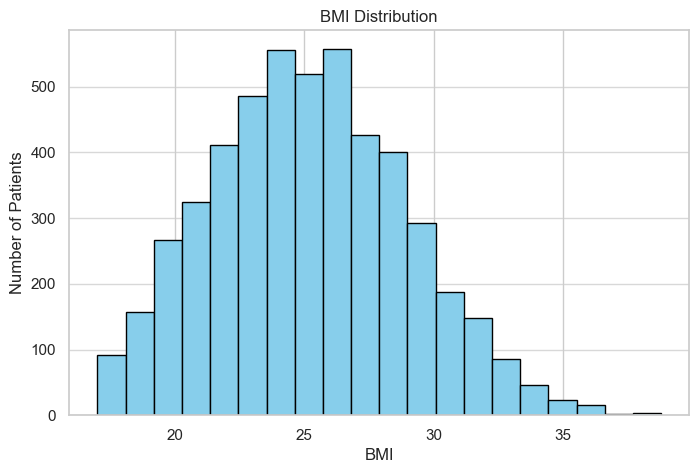

In [479]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(patients_df['bmi'], bins=20, color='skyblue', edgecolor='black')
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Number of Patients')
plt.grid(axis='y', alpha=0.75)
plt.show()


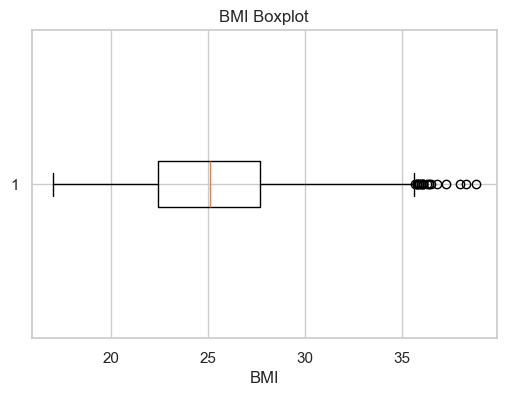

In [478]:
plt.figure(figsize=(6,4))
plt.boxplot(patients_df['bmi'], vert=False)
plt.title('BMI Boxplot')
plt.xlabel('BMI')
plt.show()


In [481]:
patients_df['bmi_standardized']

0      -0.338152
1       1.731222
2       0.616944
3       0.245518
4      -1.027943
          ...   
4995    1.306735
4996   -1.187125
4997   -0.470804
4998    0.935309
4999    0.245518
Name: bmi_standardized, Length: 5000, dtype: float64

In [436]:
patients_df['bmi']

0       23.9
1       31.7
2       27.5
3       26.1
4       21.3
        ... 
4995    30.1
4996    20.7
4997    23.4
4998    28.7
4999    26.1
Name: bmi, Length: 5000, dtype: float64

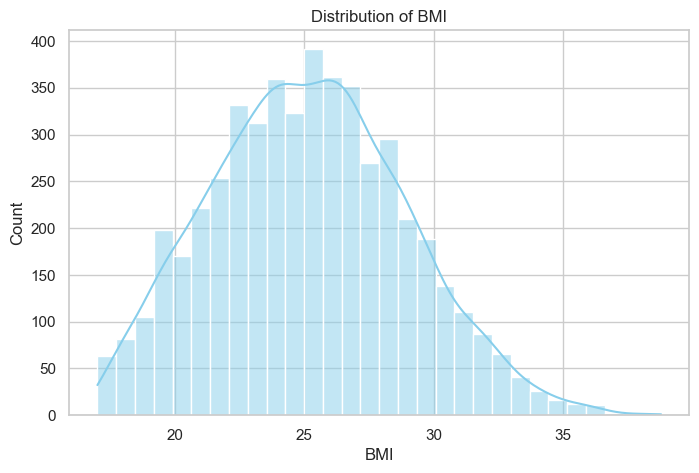

In [437]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the histogram with KDE (smooth line)
plt.figure(figsize=(8, 5))
sns.histplot(patients_df['bmi'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.grid(True)
plt.show()


In [438]:
# Check skewness
print("Skewness of BMI:", patients_df['bmi'].skew())

# Check summary stats
print("\nSummary statistics:")
print(patients_df['bmi'].describe())


Skewness of BMI: 0.20940073980881693

Summary statistics:
count    5000.000000
mean       25.174580
std         3.769633
min        17.000000
25%        22.400000
50%        25.100000
75%        27.700000
max        38.800000
Name: bmi, dtype: float64


- step F-2
    -  Binning e.g.
        - age - age_group (putting the age values into age range or categories)

In [ ]:
import numpy as np
# Add age group column for segmentation
bins = [0, 18, 35, 55, np.inf]
labels = ['0-18', '19-35', '36-55', '55+']
# Create age group column
patients_df['age_group'] = pd.cut(patients_df['age'], bins=bins, labels=labels)
# Preview result
patients_df.head(2)

In [ ]:
# Preview result
print(patients_df[['age', 'age_group']].head())

In [377]:
patients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   patient_id       5000 non-null   int64         
 1   age              5000 non-null   int64         
 2   gender           5000 non-null   object        
 3   bmi              5000 non-null   float64       
 4   smoker           5000 non-null   bool          
 5   chronic_cond     5000 non-null   object        
 6   injury_type      5000 non-null   object        
 7   signup_date      5000 non-null   datetime64[ns]
 8   referral_source  5000 non-null   object        
 9   consent          5000 non-null   bool          
 10  clinic_id        5000 non-null   int64         
 11  insurance_type   5000 non-null   object        
dtypes: bool(2), datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 400.5+ KB


In [383]:
patients_df['bmi'].nunique()

199

In [429]:
import pandas as pd
import numpy as np

bins=[0, 18, 30, 45, 60, np.inf]
labels=['Child', 'Young Adult', 'Adult', 'Middle Age', 'Seniors']
df_1 = pd.DataFrame({'age': [12, 18, 25, 35, 55, 65, 52, 78, 45, 38, 34, 61, 99, 60]})
df_1['age_group'] = pd.cut(df_1['age'], bins=bins, labels=labels, right=False)
print(df_1)
df_1['age_group'].value_counts()

    age    age_group
0    12        Child
1    18  Young Adult
2    25  Young Adult
3    35        Adult
4    55   Middle Age
5    65      Seniors
6    52   Middle Age
7    78      Seniors
8    45   Middle Age
9    38        Adult
10   34        Adult
11   61      Seniors
12   99      Seniors
13   60      Seniors


age_group
Seniors        5
Middle Age     3
Adult          3
Young Adult    2
Child          1
Name: count, dtype: int64

In [433]:
import pandas as pd

df_2 = pd.DataFrame({'fruit': ['Apple', 'Banana', 'Orange', 'Guava', 'Soursop', 'Pineapple', 'Lemon']})
fruit_map = {'Apple': 'Sweet', 'Banana': 'Sweet', 'Orange': 'Citrus', 'Guava': 'Sour', 'Soursop': 'Sour', 'Pineapple': 'Sweet', 'Lemon': 'Tangie'}
df_2['taste_category'] = df_2['fruit'].map(fruit_map)
print(df_2)
df_2['taste_category'].value_counts()

       fruit taste_category
0      Apple          Sweet
1     Banana          Sweet
2     Orange         Citrus
3      Guava           Sour
4    Soursop           Sour
5  Pineapple          Sweet
6      Lemon         Tangie


taste_category
Sweet     3
Sour      2
Citrus    1
Tangie    1
Name: count, dtype: int64

In [442]:
patients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   patient_id       5000 non-null   int64         
 1   age              5000 non-null   int64         
 2   gender           5000 non-null   object        
 3   bmi              5000 non-null   float64       
 4   smoker           5000 non-null   bool          
 5   chronic_cond     5000 non-null   object        
 6   injury_type      5000 non-null   object        
 7   signup_date      5000 non-null   datetime64[ns]
 8   referral_source  5000 non-null   object        
 9   consent          5000 non-null   bool          
 10  clinic_id        5000 non-null   int64         
 11  insurance_type   5000 non-null   object        
dtypes: bool(2), datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 400.5+ KB


In [443]:
patients_df['age'].describe()

count    5000.000000
mean       50.907200
std        19.403203
min        18.000000
25%        34.000000
50%        51.000000
75%        68.000000
max        84.000000
Name: age, dtype: float64

In [455]:
patients_df['age'].unique()

array([29, 68, 64, 41, 22, 83, 47, 77, 63, 70, 31, 42, 49, 51, 20, 54, 28,
       67, 79, 82, 45, 39, 78, 23, 71, 30, 26, 40, 33, 55, 62, 81, 73, 60,
       24, 38, 69, 74, 43, 37, 34, 27, 18, 65, 36, 48, 56, 25, 61, 75, 58,
       32, 84, 21, 46, 72, 19, 66, 80, 35, 57, 59, 50, 52, 53, 76, 44])

- step F-3 : TASK 4 (Data Transformation)
    - Log Transform (for highly skewed data e.g.,
        - income,
        - prices)

- step F-4 :
    - Encoding (Convert categorical variables into numerical format (e.g., 
        - One-Hot Encoding,
        - Label Encoding))

In [355]:
patients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   patient_id       5000 non-null   int64         
 1   age              5000 non-null   int64         
 2   gender           5000 non-null   object        
 3   bmi              5000 non-null   float64       
 4   smoker           5000 non-null   bool          
 5   chronic_cond     5000 non-null   object        
 6   injury_type      5000 non-null   object        
 7   signup_date      5000 non-null   datetime64[ns]
 8   referral_source  5000 non-null   object        
 9   consent          5000 non-null   bool          
 10  clinic_id        5000 non-null   int64         
 11  insurance_type   5000 non-null   object        
dtypes: bool(2), datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 400.5+ KB


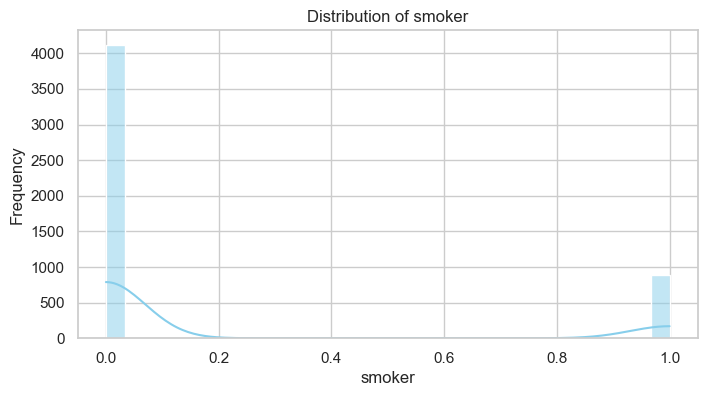

In [376]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.histplot(patients_df['smoker'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of smoker')
plt.xlabel('smoker')
plt.ylabel('Frequency')
plt.show()


In [375]:
patients_df['insurance_type'].value_counts()

insurance_type
Public             2562
Private-Basic      1300
Private-Premium     577
Private-Top-Up      561
Name: count, dtype: int64

(G) - Data Distribution
- G-1 Histograms for distributions of numerical features

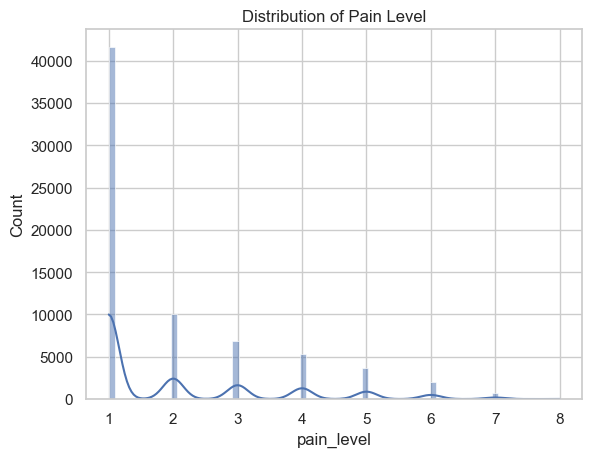

In [483]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogram for distribution of pain level
sns.histplot(sessions_df['pain_level'], kde=True)
plt.title('Distribution of Pain Level')
plt.show()

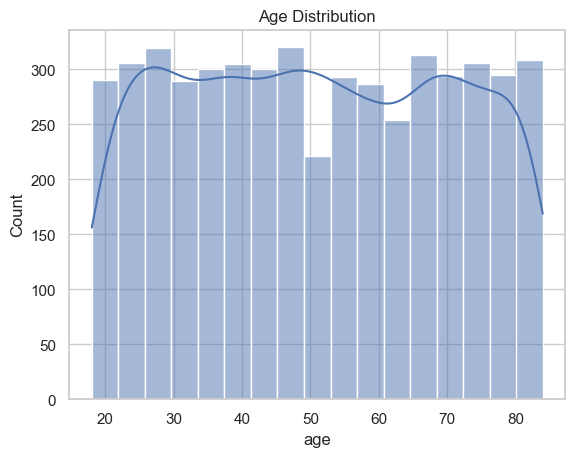

In [482]:
# Age distribution for patients (histogram)
sns.histplot(patients_df['age'], kde=True)
plt.title('Age Distribution')
plt.show()

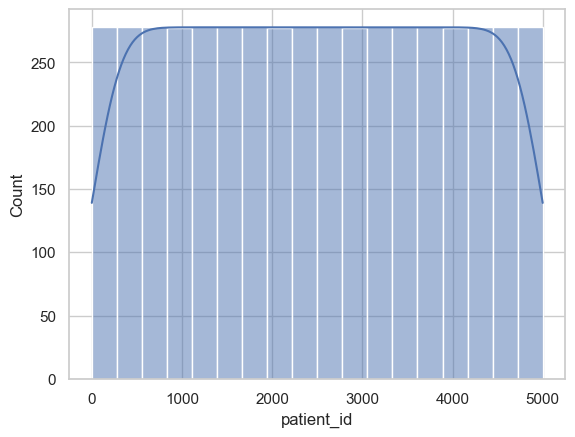

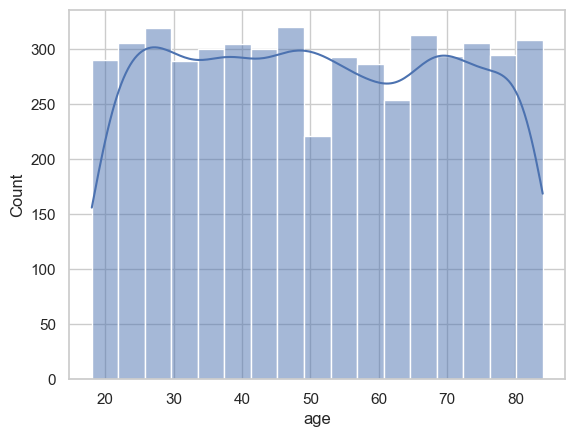

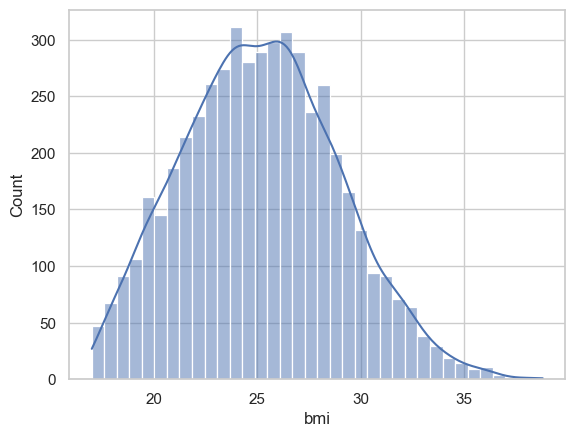

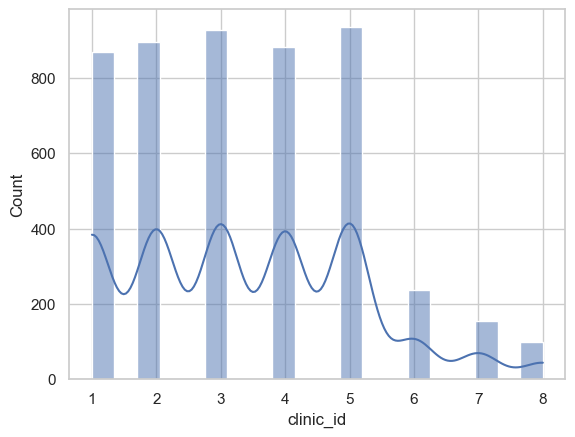

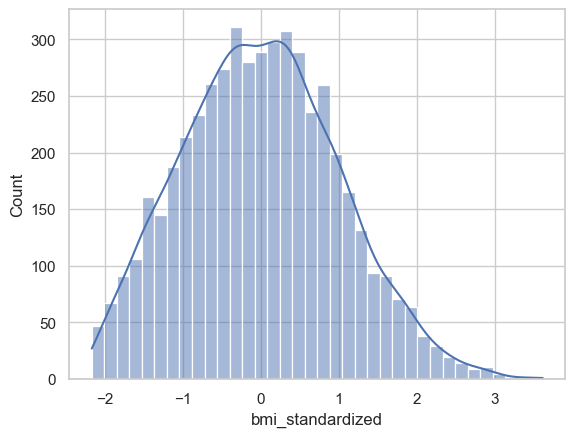

In [ ]:
# Histogram to understand the patients distribution
# Visual exploration of the patients data
for i in patients_df.select_dtypes(include='number').columns:
    sns.histplot(data=patients_df, x=i, kde=True)
    plt.show()

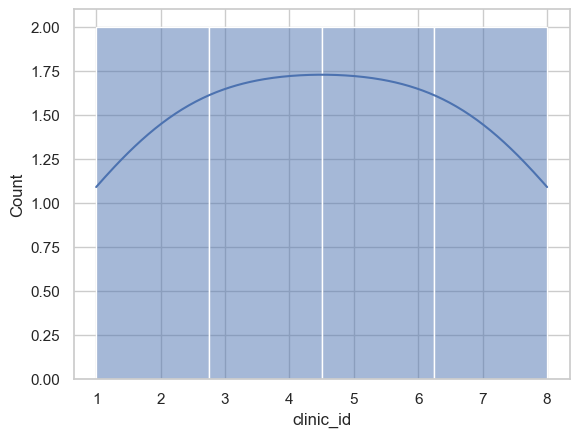

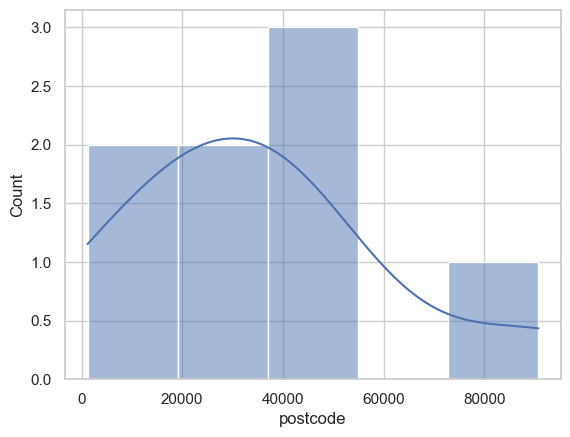

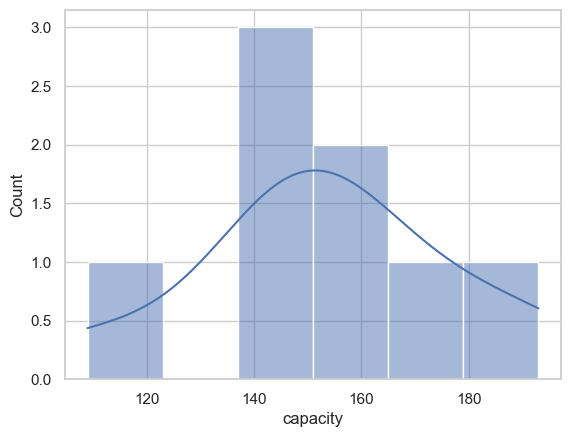

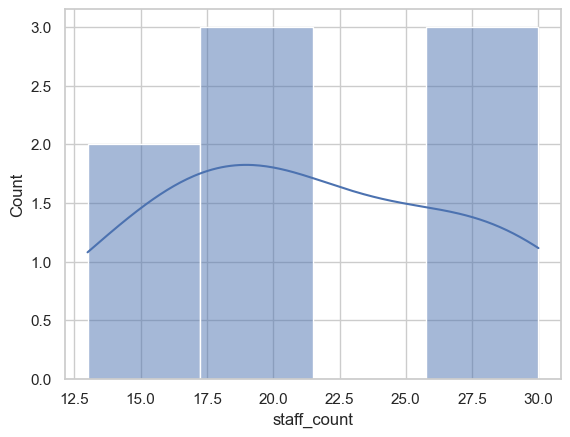

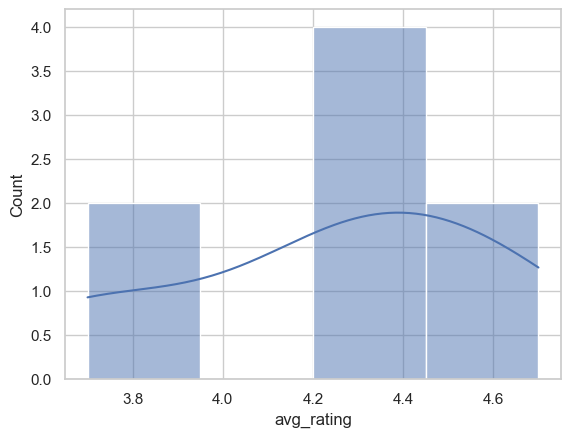

In [ ]:
# Histogram to understand the clinics distribution
# Visual exploration of the clinics data
for i in clinics_df.select_dtypes(include='number').columns:
    sns.histplot(data=clinics_df, x=i, kde=True)
    plt.show()

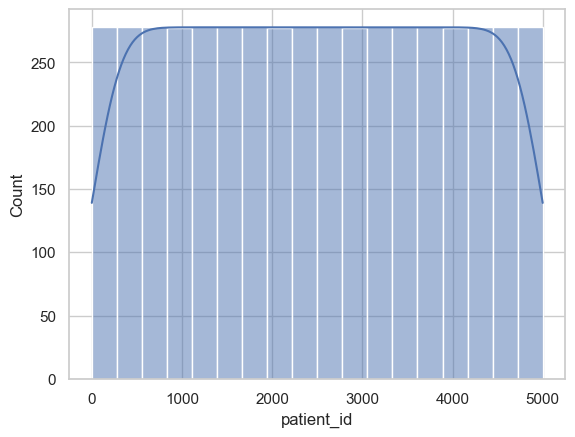

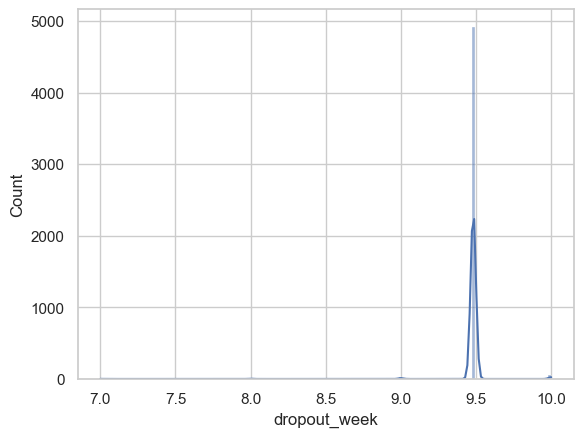

In [ ]:
# Histogram to understand the dropout_flag distribution
# Visual exploration of the dropout_flag data
for i in dropout_flags_df.select_dtypes(include='number').columns:
    sns.histplot(data=dropout_flags_df, x=i, kde=True)
    plt.show()

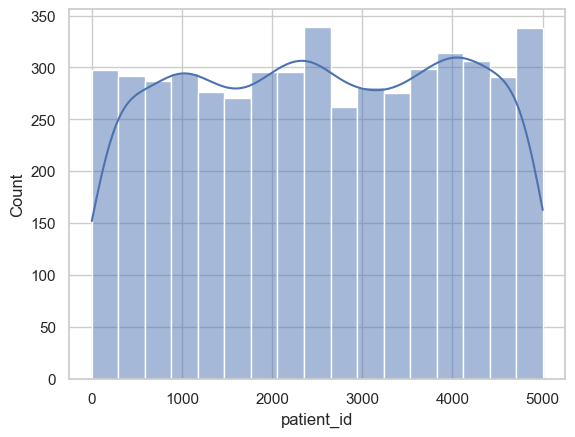

In [ ]:
# Histogram to understand the interventions distribution
# Visual exploration of the interventions data
for i in interventions_df.select_dtypes(include='number').columns:
    sns.histplot(data=interventions_df, x=i, kde=True)
    plt.show()

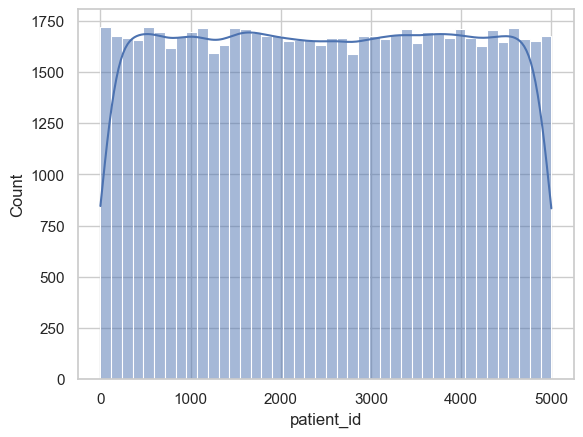

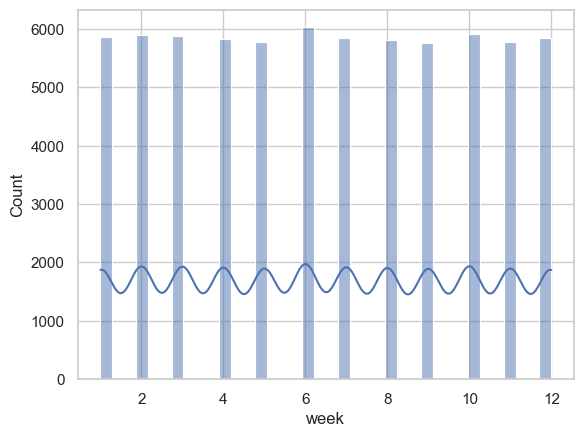

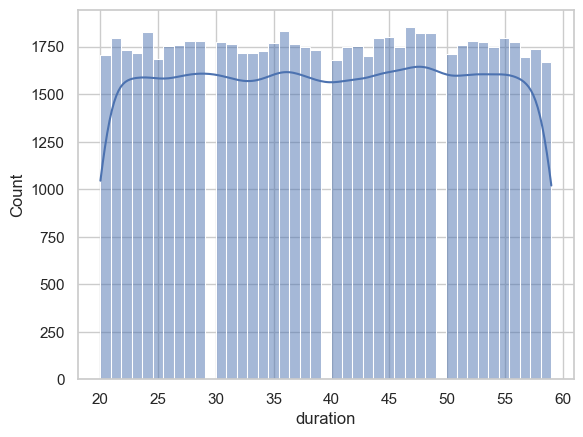

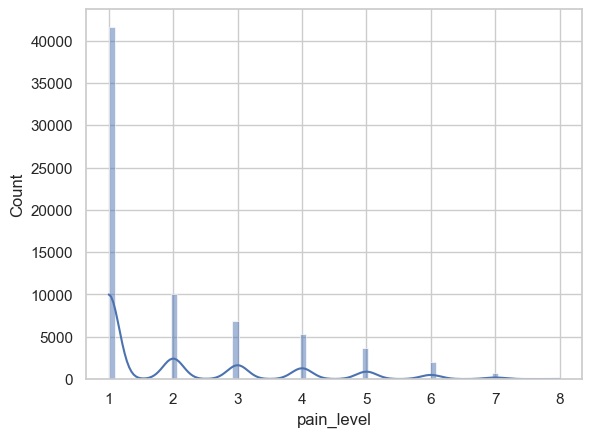

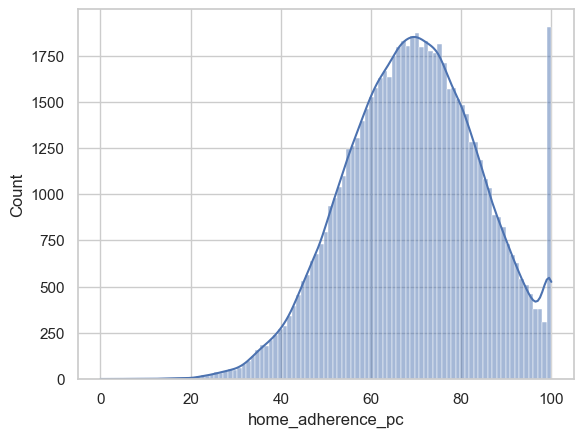

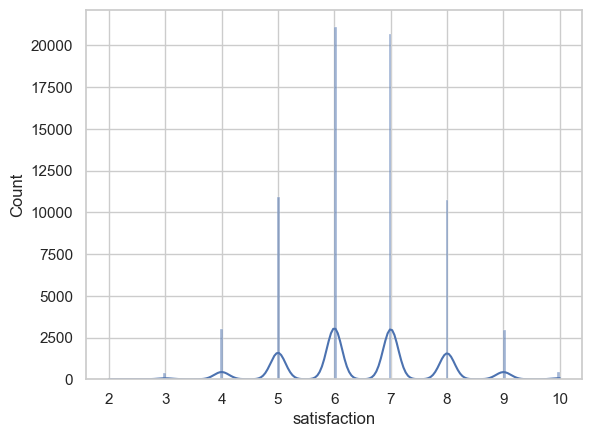

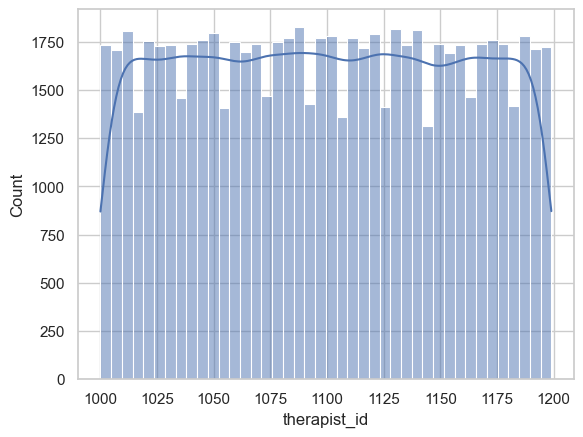

In [ ]:
# Histogram to understand the sessions distribution
# Visual exploration of the sessions data
for i in sessions_df.select_dtypes(include='number').columns:
    sns.histplot(data=sessions_df, x=i, kde=True)
    plt.show()

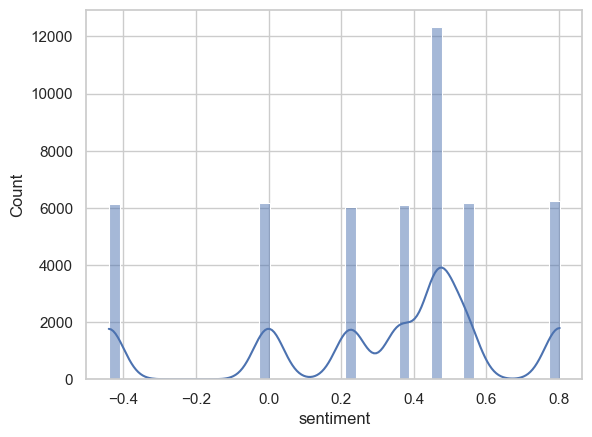

In [ ]:
# Histogram to understand the feedback distribution
# Visual exploration of the feedback data
for i in feedback_df.select_dtypes(include='number').columns:
    sns.histplot(data=feedback_df, x=i, kde=True)
    plt.show()

- G-2 TASK 5 (Data Distribution)

- Boxplots to detect outliers & handle them.
- Pairplots to visualize relationships between multiple features.


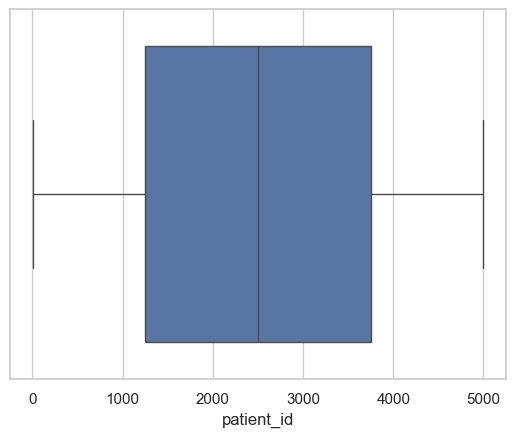

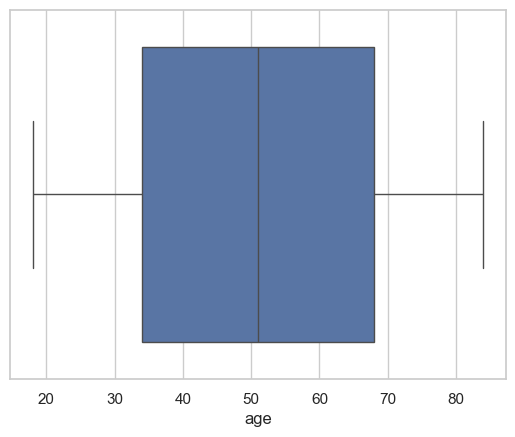

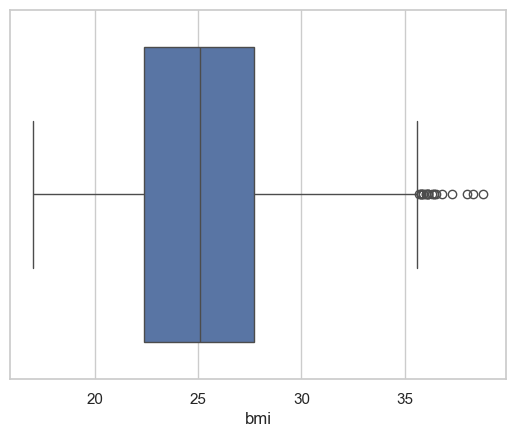

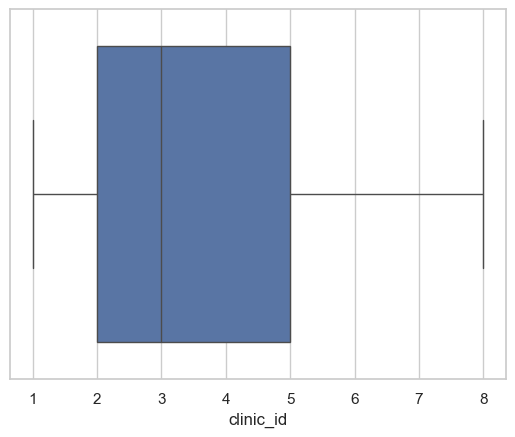

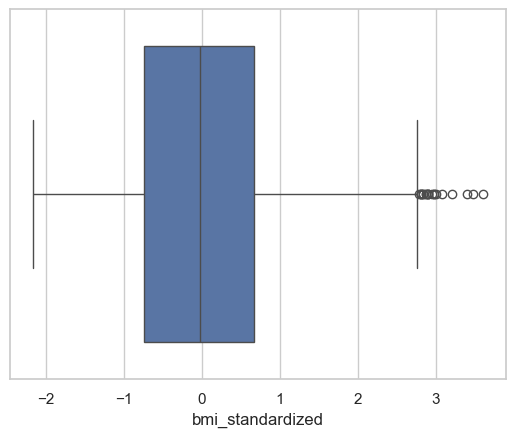

In [498]:
# Visual exploration of the patients data
# Boxplots to detect outliers in the patients data

for i in patients_df.select_dtypes(include='number').columns:
    sns.boxplot(data=patients_df, x=i)
    plt.show()

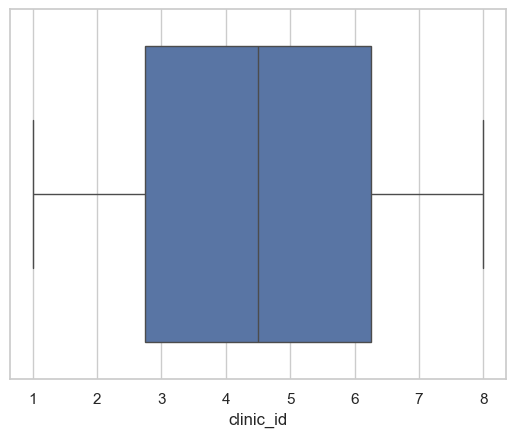

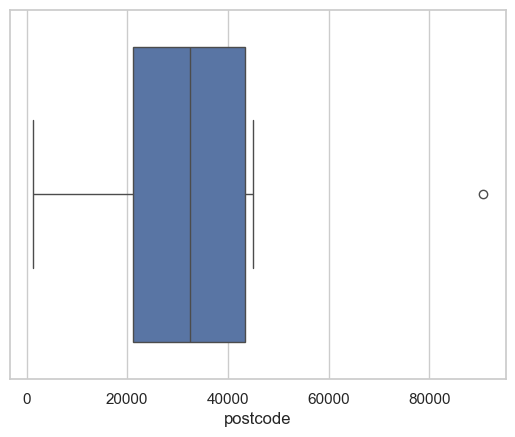

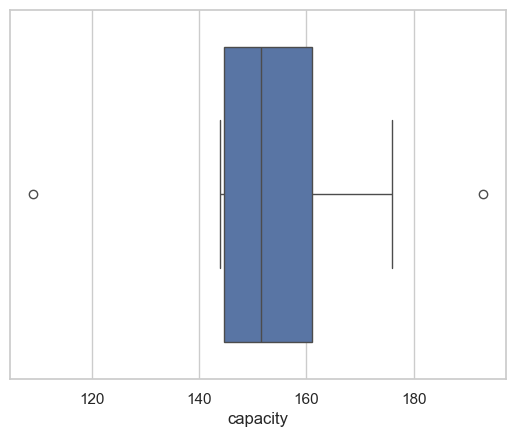

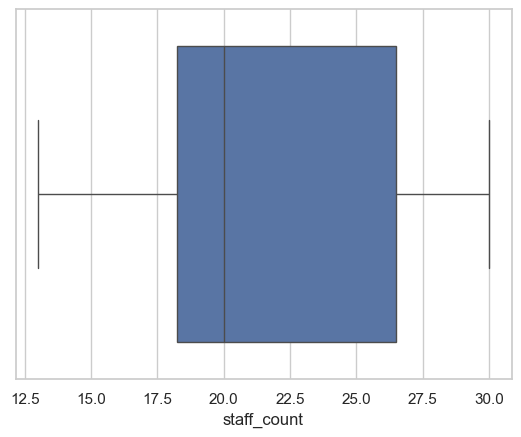

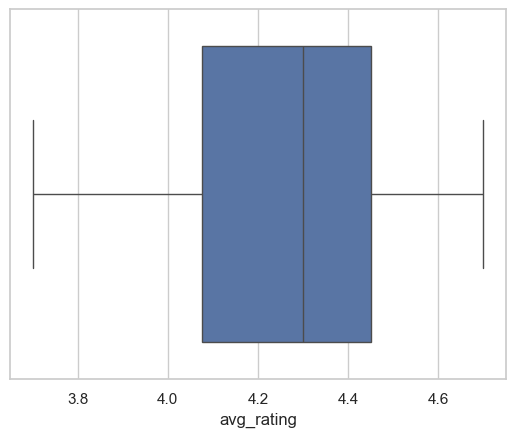

In [499]:
# Visual exploration of the clinics data
# Boxplots to detect outliers in the clinics data

for i in clinics_df.select_dtypes(include='number').columns:
    sns.boxplot(data=clinics_df, x=i)
    plt.show()

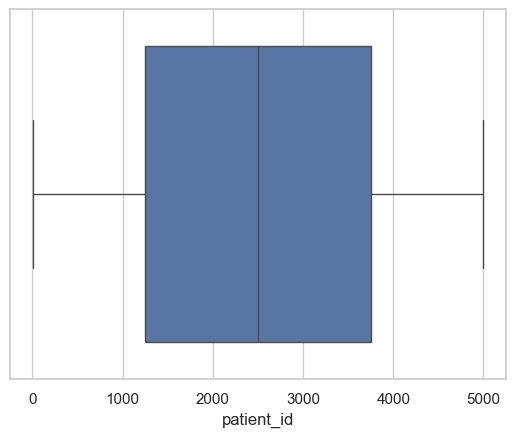

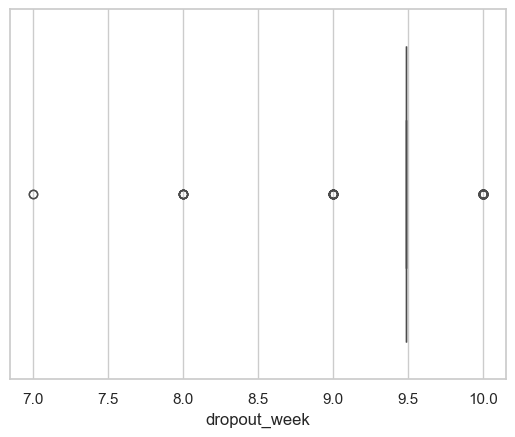

In [500]:
# Visual exploration of the dropout_flags data
# Boxplots to detect outliers in the dropout_flags data

for i in dropout_flags_df.select_dtypes(include='number').columns:
    sns.boxplot(data=dropout_flags_df, x=i)
    plt.show()

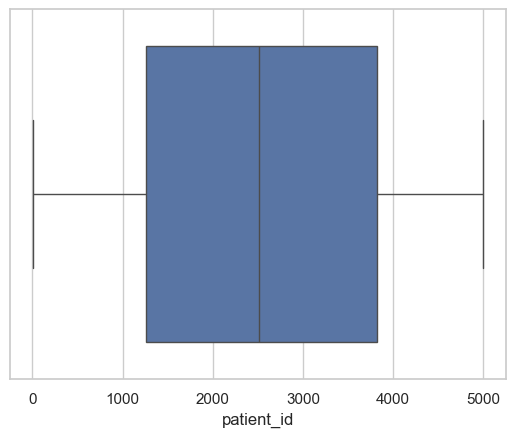

In [501]:
# Visual exploration of the interventions data
# Boxplots to detect outliers in the interventions data

for i in interventions_df.select_dtypes(include='number').columns:
    sns.boxplot(data=interventions_df, x=i)
    plt.show()

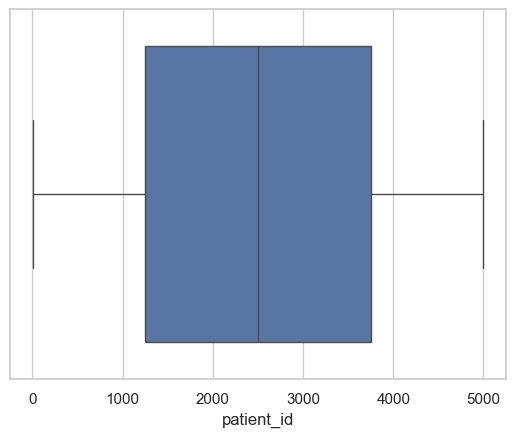

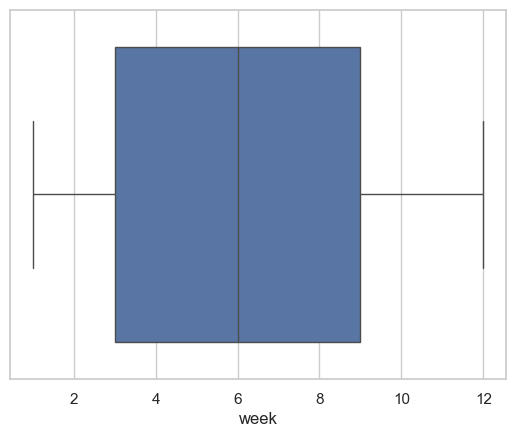

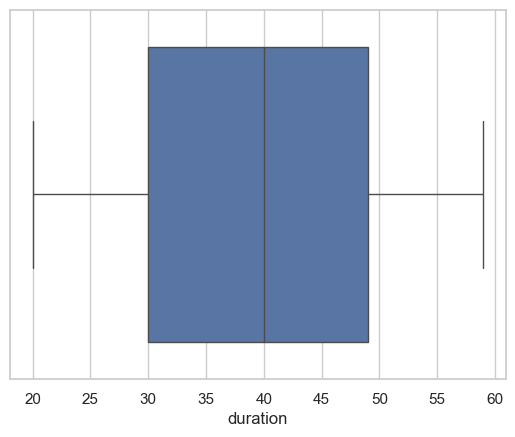

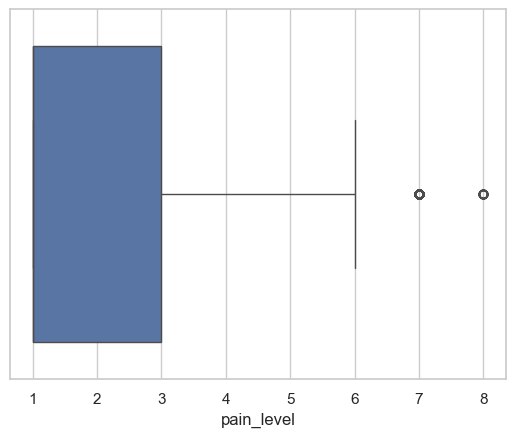

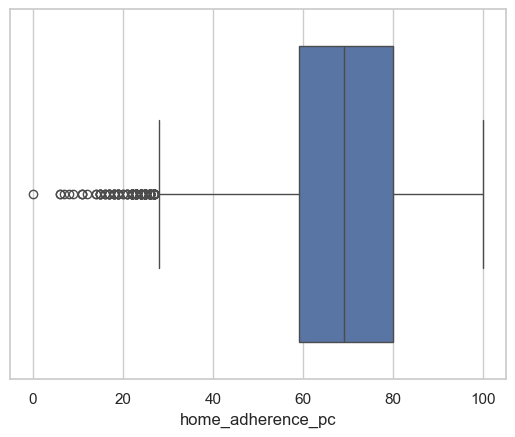

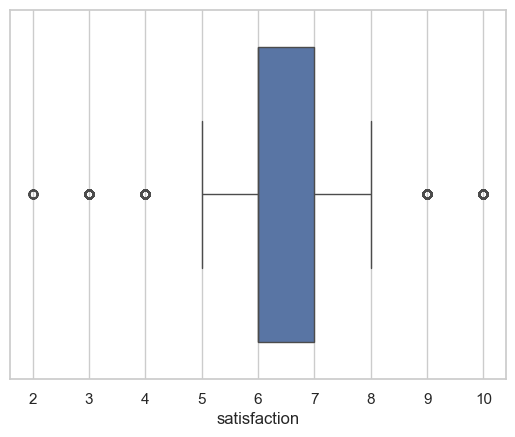

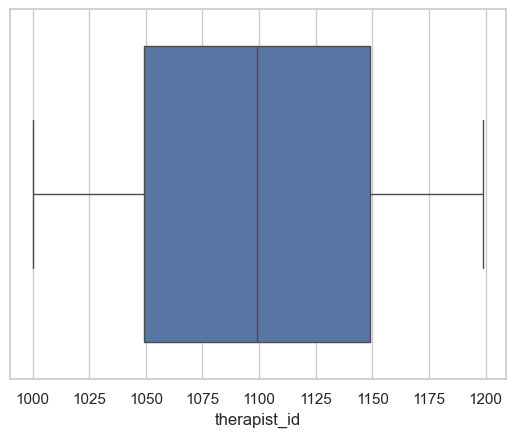

In [502]:
# Visual exploration of the sessions data
# Boxplots to detect outliers in the sessions data

for i in sessions_df.select_dtypes(include='number').columns:
    sns.boxplot(data=sessions_df, x=i)
    plt.show()

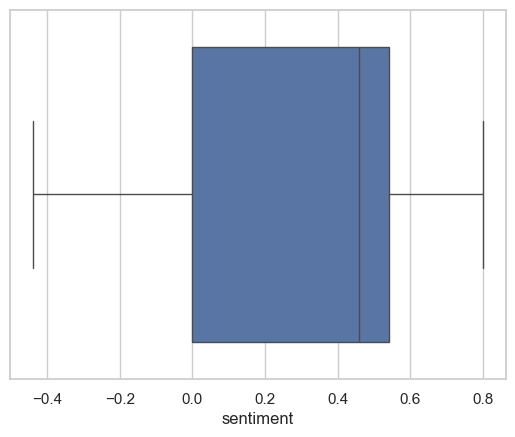

In [503]:
# Visual exploration of the feedback data
# Boxplots to detect outliers in the feedback data

for i in feedback_df.select_dtypes(include='number').columns:
    sns.boxplot(data=feedback_df, x=i)
    plt.show()

(H) - CORRELATION ANALYSIS
- H-1 TASK 6 (Correlation Analysis)
    - Correlation Analysis (dentify relationships between variables that may help in predictive modeling)
    - Correlation Matrix to understand feature dependencies.
    - Heatmap for visual representation of correlations.


In [ ]:
import numpy as np

In [120]:
A = np.array([[1, 2], [3, 4]])

B = np.array([[2, 1], [3, 1]])

In [121]:
M = A @ B

In [122]:
print(M)

[[ 8  3]
 [18  7]]


In [133]:
C = np.array([[2, 24], [2, 26], [2, 57], [1, 37]])

D = np.array([[1000], [150]])

In [134]:
E = C @ D

In [135]:
print(E)

[[ 5600]
 [ 5900]
 [10550]
 [ 6550]]


In [137]:
bill = ([[3913], [2682], [8617], [64400]])

In [140]:
error = bill - E

In [141]:
error

array([[-1687],
       [-3218],
       [-1933],
       [57850]])

In [ ]:
billpred = constant([[2000, 3600], [2000, 3900], [2000, 8550], [1000, 5550]])

In [ ]:
patients_df.drop(columns='chronic_cond_encoded', inplace=True)


In [341]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


In [342]:
# Normal distribution
normal_data = np.random.normal(loc=50, scale=10, size=1000)

# Right-skewed distribution
right_skewed = np.random.exponential(scale=10, size=1000)

# Left-skewed distribution (by taking negative of right-skewed and shifting)
left_skewed = -np.random.exponential(scale=10, size=1000) + 100


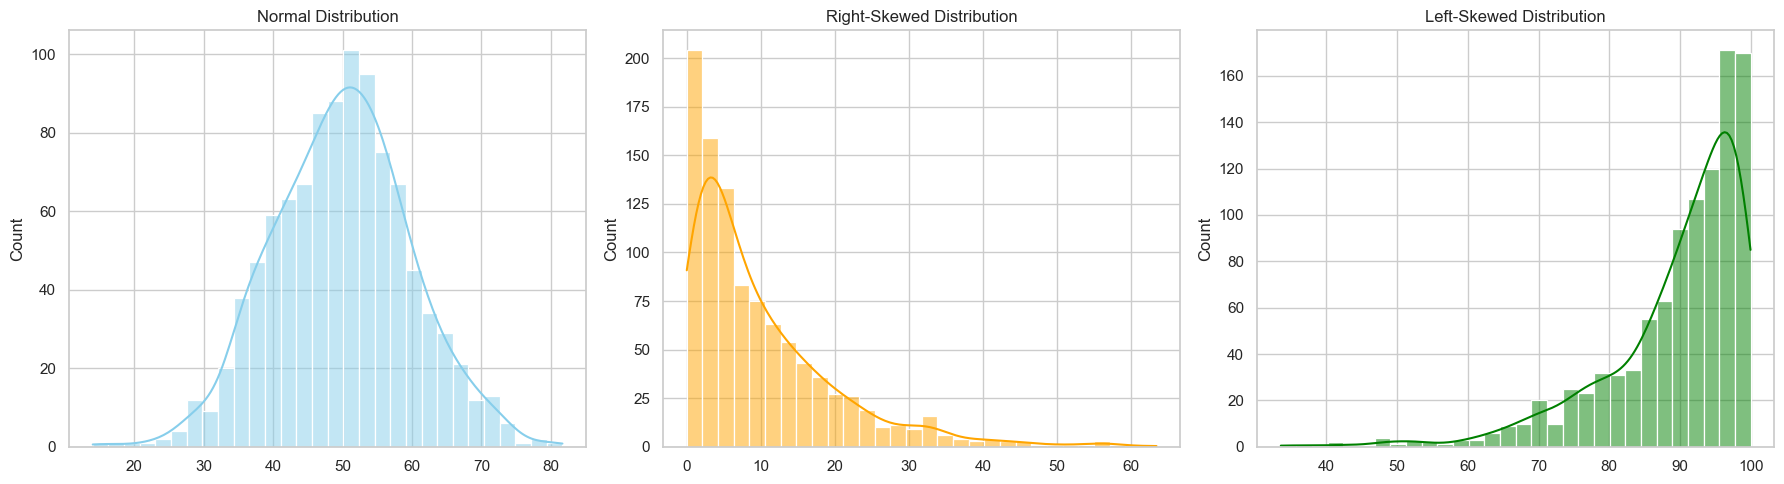

In [346]:
plt.figure(figsize=(18, 5))

# Normal
plt.subplot(1, 3, 1)
sns.histplot(normal_data, bins=30, kde=True, color='skyblue')
plt.title('Normal Distribution')

# Right-Skewed
plt.subplot(1, 3, 2)
sns.histplot(right_skewed, bins=30, kde=True, color='orange')
plt.title('Right-Skewed Distribution')

# Left-Skewed
plt.subplot(1, 3, 3)
sns.histplot(left_skewed, bins=30, kde=True, color='green')
plt.title('Left-Skewed Distribution')

plt.tight_layout()
plt.show()


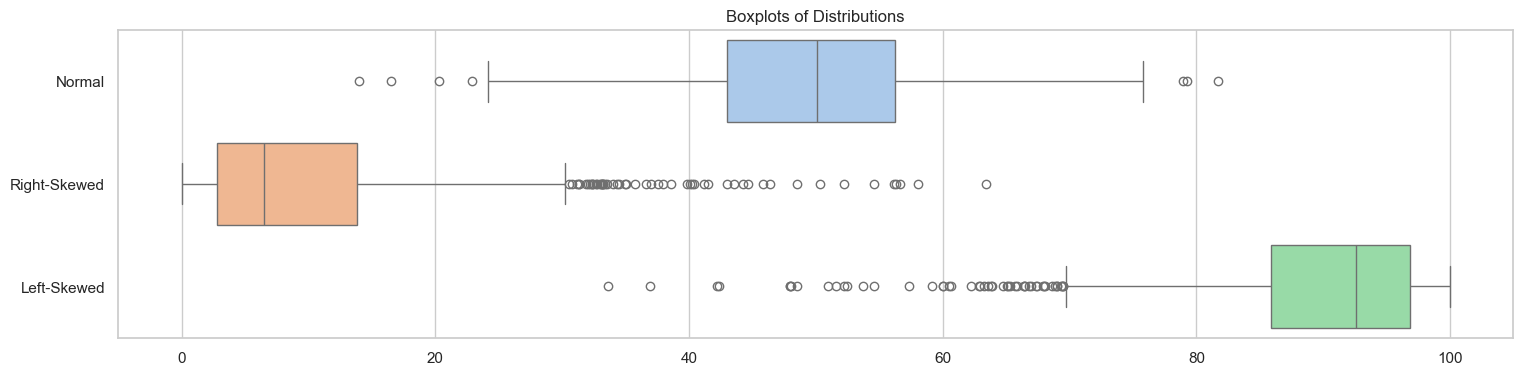

In [347]:
plt.figure(figsize=(18, 4))

# Create a DataFrame for boxplotting
df_example = pd.DataFrame({
    'Normal': normal_data,
    'Right-Skewed': right_skewed,
    'Left-Skewed': left_skewed
})

sns.boxplot(data=df_example, orient="h", palette="pastel")
plt.title("Boxplots of Distributions")
plt.show()


In [ ]:
import pandas as pd
import numpy as np

bins=[0, 18, 30, 45, 60, np.inf]
labels=['Child', 'Young Adult', 'Adult', 'Middle Age', 'Seniors']
df_1 = pd.DataFrame({'age': [12, 18, 25, 35, 55, 65, 52, 78, 45, 38, 34, 61, 99, 60]})
df_1['age_group'] = pd.cut(df_1['age'], bins=bins, labels=labels, right=False)
print(df_1)
df_1['age_group'].value_counts()

    age    age_group
0    12        Child
1    18  Young Adult
2    25  Young Adult
3    35        Adult
4    55   Middle Age
5    65      Seniors
6    52   Middle Age
7    78      Seniors
8    45   Middle Age
9    38        Adult
10   34        Adult
11   61      Seniors
12   99      Seniors
13   60      Seniors


age_group
Seniors        5
Middle Age     3
Adult          3
Young Adult    2
Child          1
Name: count, dtype: int64

In [435]:
import pandas as pd
import numpy as np

bins=[0, 18, 30, 45, 60, np.inf]
labels=['Child', 'Young Adult', 'Adult', 'Middle Age', 'Seniors']
df_1 = pd.DataFrame({'age': [12, 18, 25, 35, 55, 65, 52, 78, 45, 38, 34, 61, 99, 60]})
df_1['age_group'] = pd.cut(df_1['age'], bins=bins, labels=labels, right=False)
print(df_1)
df_1['age_group'].value_counts()

    age    age_group
0    12        Child
1    18  Young Adult
2    25  Young Adult
3    35        Adult
4    55   Middle Age
5    65      Seniors
6    52   Middle Age
7    78      Seniors
8    45   Middle Age
9    38        Adult
10   34        Adult
11   61      Seniors
12   99      Seniors
13   60      Seniors


age_group
Seniors        5
Middle Age     3
Adult          3
Young Adult    2
Child          1
Name: count, dtype: int64